In [41]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [42]:
# Check if CUDA is available
if torch.cuda.is_available():
    # Specify device (GPU)
    device = torch.device("cuda")
    print("CUDA is available. Running on GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Running on CPU.")

# Create PyTorch tensors and move them to the specified device
a = torch.tensor([1.0, 2.0]).to(device)
b = torch.tensor([3.0, 4.0]).to(device)

# Perform operations on the tensors
c = a + b

print("Result of computation on GPU:", c)
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)

CUDA is available. Running on GPU.
Result of computation on GPU: tensor([4., 6.], device='cuda:0')
PyTorch version: 2.3.0
CUDA version: 12.1


In [43]:
# Create dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        image = Image.open(img_name)
        status = self.dataframe.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
        
        return image, status

In [44]:
BASE_DIR_YAWN = r"C:\Users\aekas\Desktop\Year 3\Term 2\FRA361 Open Topics\drowsiness detection\DRIVER-DRAWSINESS-PREDICTION\train\drowsy_notdrowsy"
image_paths = []
status_labels = []

for filename in tqdm(os.listdir(BASE_DIR_YAWN)):
    image_path = os.path.join(BASE_DIR_YAWN, filename)
    temp = filename.split('_', 1)
    status = int(temp[0])
    image_paths.append(image_path)
    status_labels.append(status)

# Create DataFrame
df = pd.DataFrame()
df['image'], df['status'] = image_paths, status_labels

100%|██████████| 1448/1448 [00:00<00:00, 241389.20it/s]


In [45]:
# # กำหนด path และ labels
# BASE_DIR_YAWN = r"train_data\drowsy_notdrowsy"
# image_paths = []
# status_labels = []

# for filename in tqdm(os.listdir(BASE_DIR_YAWN)):
#     image_path = os.path.join(BASE_DIR_YAWN, filename)
#     temp = filename.split('_', 1)
#     status = int(temp[0])
#     image_paths.append(image_path)
#     status_labels.append(status)

# # สร้าง DataFrame
# df = pd.DataFrame()
# df['image'], df['status'] = image_paths, status_labels

In [46]:
image_paths = np.array(image_paths)
status_labels = np.array(status_labels)
print("Total images:", len(image_paths))
print("Total labels:", len(status_labels))

Total images: 1448
Total labels: 1448


In [47]:
# Convert to dataframe
df = pd.DataFrame()
df['image'], df['status'] = image_paths, status_labels
df.head()

image  status
0  C:\Users\aekas\Desktop\Year 3\Term 2\FRA361 Op...       0
1  C:\Users\aekas\Desktop\Year 3\Term 2\FRA361 Op...       0
2  C:\Users\aekas\Desktop\Year 3\Term 2\FRA361 Op...       0
3  C:\Users\aekas\Desktop\Year 3\Term 2\FRA361 Op...       0
4  C:\Users\aekas\Desktop\Year 3\Term 2\FRA361 Op...       0

<Axes: ylabel='count'>

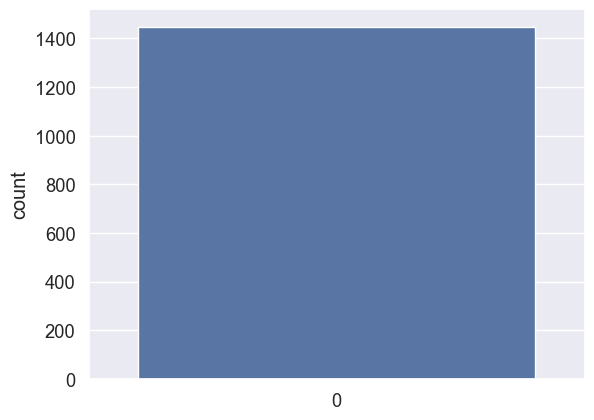

In [48]:
import seaborn as sns
sns.countplot(df['status'])

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1448 entries, 0 to 1447
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   1448 non-null   object
 1   status  1448 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 17.1+ KB


In [50]:
# Map labels for status
status_dict = {0:'Non drowsy', 1:'Drowsy'}

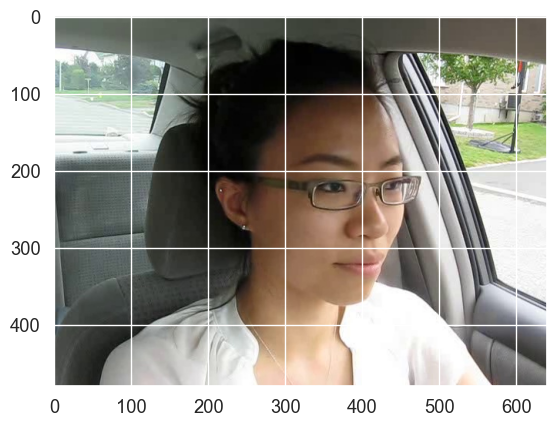

Image shape: (640, 480)
Number of channels: 3


In [51]:
random_index = random.randint(0, len(df) - 1)
random_image_path = df.iloc[random_index]['image']
img = Image.open(random_image_path)

plt.axis()
plt.imshow(img)
plt.show()

print("Image shape:", img.size)
num_channels = img.getbands()
print("Number of channels:", len(num_channels))

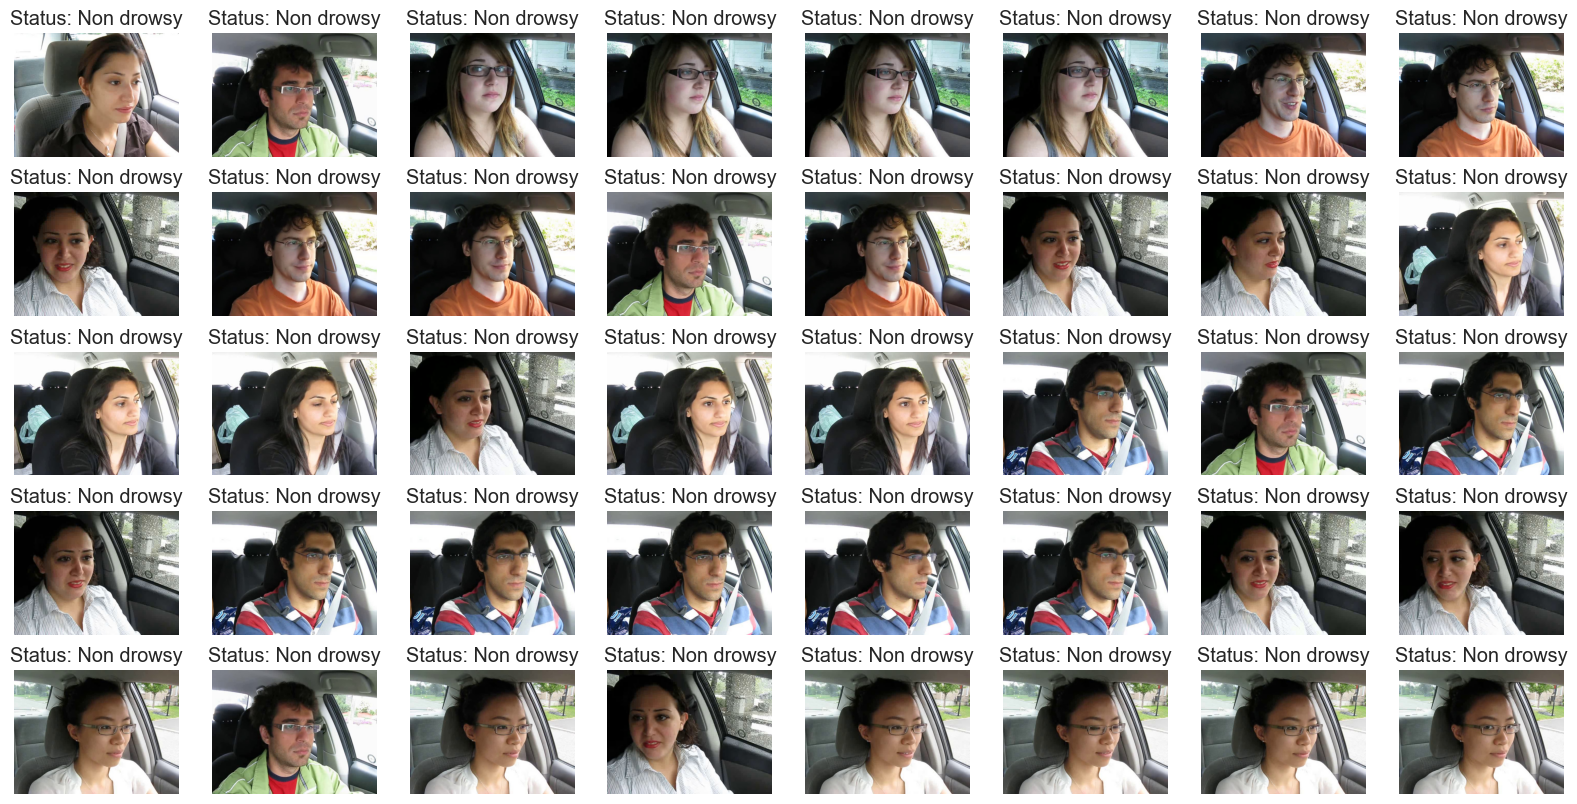

In [52]:
# to display grid of images
plt.figure(figsize=(20, 10))
files = df.iloc[0:40]

for index, file, status in files.itertuples():
    plt.subplot(5, 8, index+1)
    img = Image.open(file)
    img = np.array(img)
    
    plt.imshow(img)
    plt.title(f"Status: {status_dict[status]}")
    plt.axis('off')

100%|██████████| 1/1 [00:00<00:00, 199.93it/s]


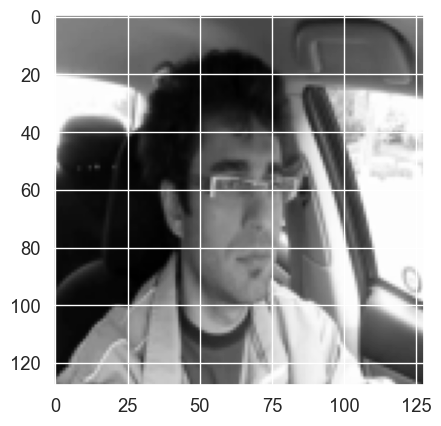

In [53]:
# Define the transformation outside of the extract_features function
transform = transforms.Compose([
    transforms.Resize((128, 128,)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = Image.open(image)
        img = transform(img)  
        features.append(img)

    features = torch.stack(features)
    return features

# plt.imshow(extract_features([image_paths[33]])[0].squeeze().numpy(), cmap='gray')
plt.imshow(extract_features([image_paths[33]])[0].view(128, 128).numpy(), cmap='gray')
plt.show()


In [54]:
image_size = extract_features(df['image'])
image_size.shape

100%|██████████| 1448/1448 [00:04<00:00, 360.77it/s]


torch.Size([1448, 1, 128, 128])

In [55]:
# Define hyperparameters
batch_size=32
num_epochs=30
learning_rate=0.001

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
print("Train size:", len(train_df))
print("Test size:", len(test_df))

train_dataset = CustomDataset(train_df, transform=transform)  
test_dataset = CustomDataset(test_df, transform=transform)
print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("Train loader size:", len(train_loader))
print("Test loader size:", len(test_loader))

Train size: 1158
Test size: 290
Train dataset size: 1158
Test dataset size: 290
Train loader size: 37
Test loader size: 10


In [56]:
# Create dataset from DataFrame and defind change image (transform)
custom_dataset = CustomDataset(dataframe=train_df, transform=transform)

# Create DataLoader to extract information from Dataset the form is divided into batches and shuffle the data 
train_loader = DataLoader(dataset=custom_dataset, batch_size=batch_size, shuffle=True)

# วน loop เพื่อดึงข้อมูลจาก DataLoader
for images, statuses in train_loader:
    batch_size_current = images.size(0)

    # Display the size of batch and data image and status in batch
    print(f'Batch size: {batch_size_current}')
    print('Images:', images)
    print('Statuses:', statuses)

    break

Batch size: 32
Images: tensor([[[[ 0.1765,  0.1765,  0.1843,  ..., -0.4353, -0.4431, -0.4275],
          [ 0.1765,  0.1843,  0.1922,  ..., -0.4353, -0.4431, -0.4275],
          [ 0.1843,  0.1922,  0.2000,  ..., -0.4353, -0.4431, -0.4431],
          ...,
          [-0.1294, -0.6235, -0.9686,  ..., -0.2235, -0.0980,  0.4667],
          [-0.4431, -0.7961, -0.9608,  ..., -0.0353,  0.5608,  0.9373],
          [-0.8118, -0.9137, -0.9608,  ...,  0.6314,  0.9529,  0.9686]]],


        [[[-0.1451, -0.1451, -0.1529,  ..., -0.3176, -0.3098, -0.3020],
          [-0.1294, -0.1373, -0.1529,  ..., -0.3020, -0.3020, -0.3098],
          [-0.1059, -0.1137, -0.1373,  ..., -0.3020, -0.3020, -0.3098],
          ...,
          [-0.4980, -0.5765, -0.6314,  ..., -0.3961, -0.3882, -0.3961],
          [-0.5137, -0.5765, -0.6314,  ..., -0.3961, -0.3804, -0.4039],
          [-0.5373, -0.5765, -0.6392,  ..., -0.3961, -0.3804, -0.4039]]],


        [[[ 0.9216,  0.9216,  0.9216,  ...,  0.2392,  0.2392,  0.2392],
   

In [57]:
# import torch.nn as nn

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, kernel_size=3)                
#         self.relu1 = nn.ReLU()
#         self.pool1 = nn.MaxPool2d(kernel_size=2)  
        
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3)               
#         self.relu2 = nn.ReLU()
#         self.pool2 = nn.MaxPool2d(kernel_size=2)  
        
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3)                  
#         self.relu3 = nn.ReLU()
#         self.pool3 = nn.MaxPool2d(kernel_size=2)  
        
#         self.conv4 = nn.Conv2d(128, 256, kernel_size=3)             
#         self.relu4 = nn.ReLU()
#         self.pool4 = nn.MaxPool2d(kernel_size=2)  
        
#         self.dropout = nn.Dropout(0.5)
#         self.fc1 = nn.Linear(6 * 6 * 256, 256)                      
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(256, 1)
#         self.sigmoid = nn.Sigmoid()
        
#     def forward(self, x):
#         x = self.pool1(self.relu1(self.conv1(x)))
#         x = self.pool2(self.relu2(self.conv2(x)))
#         x = self.pool3(self.relu3(self.conv3(x)))
#         x = self.pool4(self.relu4(self.conv4(x)))
#         x = x.view(-1, 6 * 6 * 256)                                     
#         x = self.dropout(x)
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.fc2(x)
#         x = self.sigmoid(x)
#         return x

# model = CNN().to(device)
# print(model)

In [58]:
import torch.nn as nn

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)                
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)  
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)               
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)  
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)                  
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)  
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)             
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2)  
        
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(6 * 6 * 256, 256)                      
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.pool4(self.relu4(self.conv4(x)))
        x = x.view(-1, 6 * 6 * 256)                                     
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (relu4): ReLU()
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=256, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [59]:
# Check if the model is on the GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Track losses and accuracies
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    train_loss = 0.0
    test_loss = 0.0
    train_correct = 0
    test_correct = 0

    # Training loop
    model.train()
    for images, labels in train_loader:
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        labels = labels.float().unsqueeze(1)

        loss = criterion(outputs.squeeze(), labels.squeeze(1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

        # Calculate and accumulate train accuracy
        predicted = (outputs > 0.5).float()  
        train_correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = train_correct / len(train_loader.dataset)
    train_accuracies.append(train_accuracy)

    # Testing loop
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.cuda()
            labels = labels.cuda()
            outputs = model(images)
            labels = labels.float().unsqueeze(1)

            loss = criterion(outputs.squeeze(), labels.squeeze(1))
            test_loss += loss.item() * images.size(0)

            # Calculate and accumulate test accuracy
            predicted = (outputs > 0.5).float()
            test_correct += (predicted == labels).sum().item()

    test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracy = test_correct / len(test_loader.dataset)
    test_accuracies.append(test_accuracy)

    print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch: 1/30, Train Loss: 0.6399, Train Accuracy: 0.6019, Test Loss: 0.6279, Test Accuracy: 0.5828
Epoch: 2/30, Train Loss: 0.5840, Train Accuracy: 0.6520, Test Loss: 0.6136, Test Accuracy: 0.6241
Epoch: 3/30, Train Loss: 0.5572, Train Accuracy: 0.6857, Test Loss: 0.6041, Test Accuracy: 0.6276
Epoch: 4/30, Train Loss: 0.5384, Train Accuracy: 0.7073, Test Loss: 0.5779, Test Accuracy: 0.6552
Epoch: 5/30, Train Loss: 0.4904, Train Accuracy: 0.7599, Test Loss: 0.5023, Test Accuracy: 0.7448
Epoch: 6/30, Train Loss: 0.3779, Train Accuracy: 0.8428, Test Loss: 0.3372, Test Accuracy: 0.8724
Epoch: 7/30, Train Loss: 0.2782, Train Accuracy: 0.8912, Test Loss: 0.2690, Test Accuracy: 0.8897
Epoch: 8/30, Train Loss: 0.1778, Train Accuracy: 0.9309, Test Loss: 0.2827, Test Accuracy: 0.8759
Epoch: 9/30, Train Loss: 0.1650, Train Accuracy: 0.9430, Test Loss: 0.1894, Test Accuracy: 0.9379
Epoch: 10/30, Train Loss: 0.0972, Train Accuracy: 0.9585, Test Loss: 0.1460, Test Accuracy: 0.9483
Epoch: 11/30, Train

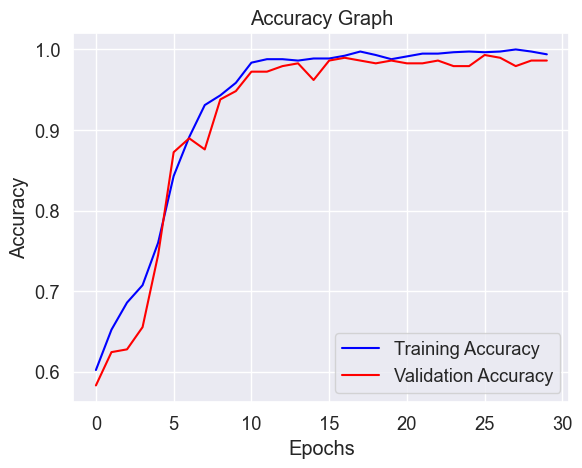

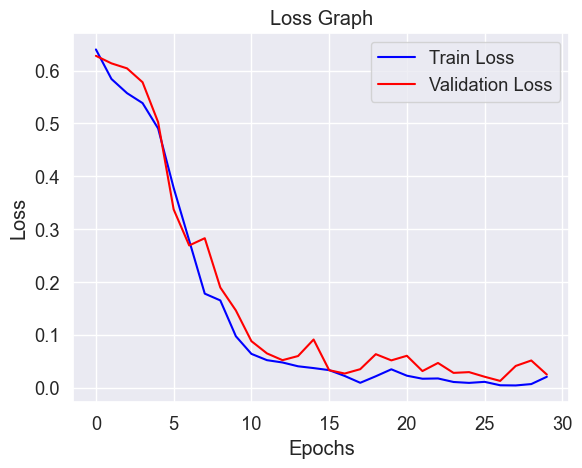

In [60]:
# Plot the training and validation accuracy
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(test_accuracies, label='Validation Accuracy', color='red')
plt.title('Accuracy Graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(test_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

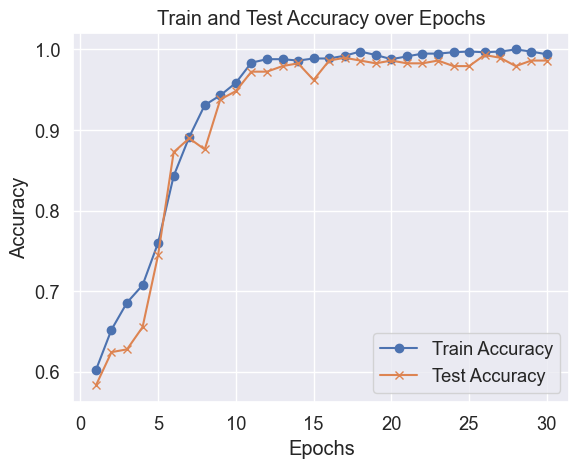

In [61]:
# Create a list of epochs for plotting
epochs = range(1, len(train_accuracies) + 1)

plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='x')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()


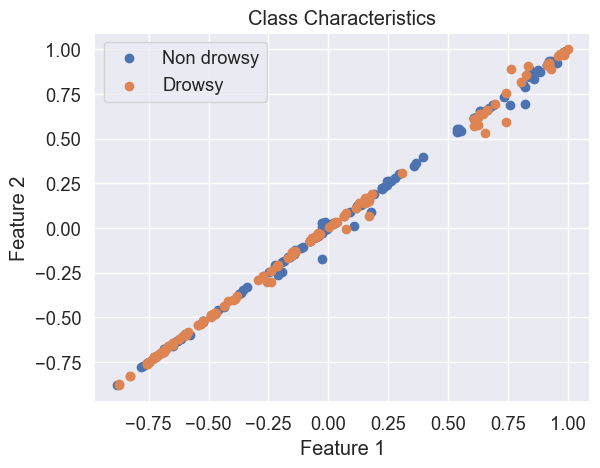

In [62]:


# Assuming X_test and y_test are your test data and labels
# Assuming status_dict is a dictionary mapping class indices to class names

# Prepare the model for evaluation
model.eval()

# Make predictions on the test set
predicted_classes = []
true_classes = []
class_features = [[] for _ in range(len(status_dict))]  # List to store features for each class

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        predicted = (outputs > 0.5).float().cpu().numpy().flatten()
        true = labels.cpu().numpy().flatten()
        predicted_classes.extend(predicted)
        true_classes.extend(true)
        
        # Store features for each class
        for i, label in enumerate(labels):
            class_index = label.item()
            class_features[class_index].append(images[i].cpu().numpy().flatten())

# Convert list to numpy array
class_features = [np.array(features) for features in class_features]

# Plot class characteristics
for i, features in enumerate(class_features):
    plt.scatter(features[:, 0], features[:, 1], label=status_dict[i])

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Class Characteristics')
plt.legend()
plt.show()


In [63]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming X_test and y_test are your test data and labels
# Assuming status_dict is a dictionary mapping class indices to class names

# Prepare the model for evaluation
model.eval()

# Make predictions on the test set
predicted_classes = []
true_classes = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        predicted = (outputs > 0.5).float().cpu().numpy().flatten()
        true = labels.cpu().numpy().flatten()
        predicted_classes.extend(predicted)
        true_classes.extend(true)

# Convert numeric labels to class names
class_names = [status_dict[i] for i in range(len(status_dict))]

print(classification_report(true_classes, predicted_classes, target_names=class_names))


              precision    recall  f1-score   support

  Non drowsy       0.98      0.99      0.99       139
      Drowsy       0.99      0.98      0.99       151

    accuracy                           0.99       290
   macro avg       0.99      0.99      0.99       290
weighted avg       0.99      0.99      0.99       290



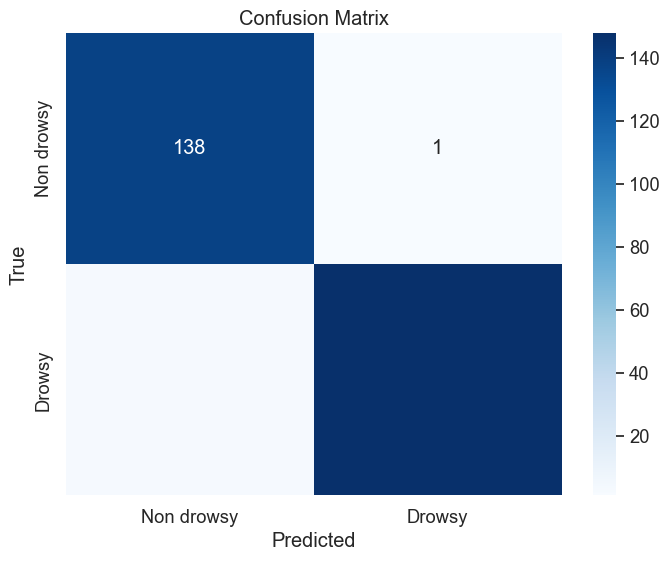

In [64]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming true_classes and predicted_classes are available from your classification_report
# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Define class names
class_names = [status_dict[i] for i in range(len(status_dict))]

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

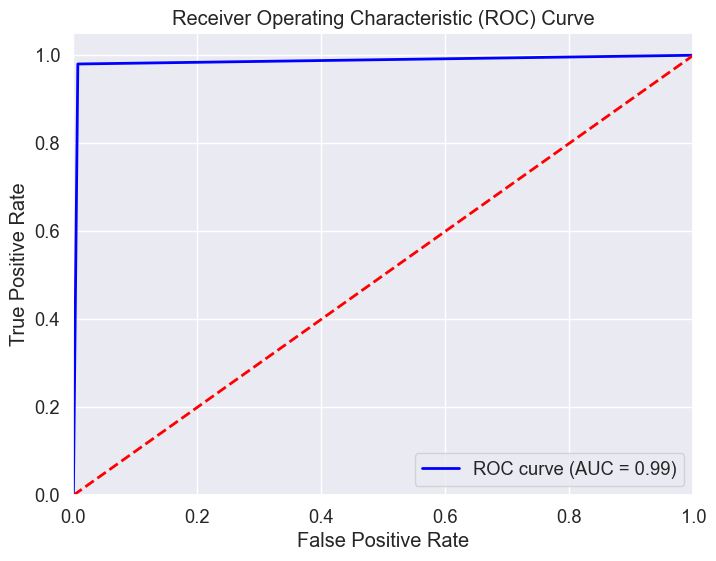

In [65]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_classes, predicted_classes)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


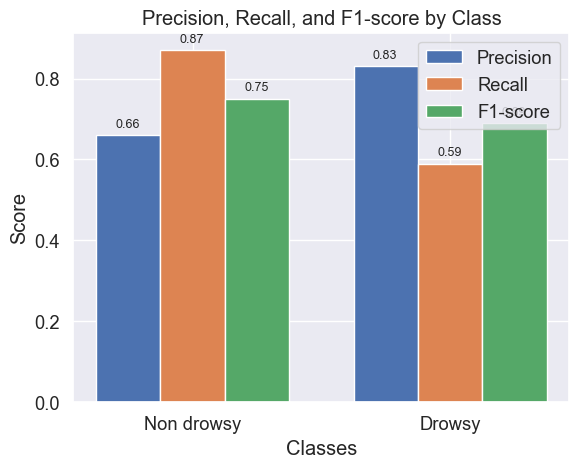

In [66]:
import matplotlib.pyplot as plt

# Precision, Recall, F1-score สำหรับแต่ละคลาส
precision_non_drowsy = 0.66
recall_non_drowsy = 0.87
f1_score_non_drowsy = 0.75

precision_drowsy = 0.83
recall_drowsy = 0.59
f1_score_drowsy = 0.69

classes = ['Non drowsy', 'Drowsy']

precision_values = [precision_non_drowsy, precision_drowsy]
recall_values = [recall_non_drowsy, recall_drowsy]
f1_score_values = [f1_score_non_drowsy, f1_score_drowsy]

bar_width = 0.25
index = range(len(classes))

plt.bar(index, precision_values, bar_width, label='Precision')
plt.bar([i + bar_width for i in index], recall_values, bar_width, label='Recall')
plt.bar([i + 2 * bar_width for i in index], f1_score_values, bar_width, label='F1-score')

for i in index:
    plt.text(i - 0.05, precision_values[i] + 0.02, f'{precision_values[i]:.2f}', fontsize=9)
    plt.text(i + bar_width - 0.05, recall_values[i] + 0.02, f'{recall_values[i]:.2f}', fontsize=9)
    plt.text(i + 2 * bar_width - 0.05, f1_score_values[i] + 0.02, f'{f1_score_values[i]:.2f}', fontsize=9)

plt.xlabel('Classes')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score by Class')
plt.xticks([i + bar_width for i in index], classes)
plt.legend()
plt.show()

Layer name: conv1, Layer type: <class 'torch.nn.modules.conv.Conv2d'>
Layer name: relu1, Layer type: <class 'torch.nn.modules.activation.ReLU'>
Layer name: pool1, Layer type: <class 'torch.nn.modules.pooling.MaxPool2d'>
Layer name: conv2, Layer type: <class 'torch.nn.modules.conv.Conv2d'>
Layer name: relu2, Layer type: <class 'torch.nn.modules.activation.ReLU'>
Layer name: pool2, Layer type: <class 'torch.nn.modules.pooling.MaxPool2d'>
Layer name: conv3, Layer type: <class 'torch.nn.modules.conv.Conv2d'>
Layer name: relu3, Layer type: <class 'torch.nn.modules.activation.ReLU'>
Layer name: pool3, Layer type: <class 'torch.nn.modules.pooling.MaxPool2d'>
Layer name: conv4, Layer type: <class 'torch.nn.modules.conv.Conv2d'>
Layer name: relu4, Layer type: <class 'torch.nn.modules.activation.ReLU'>
Layer name: pool4, Layer type: <class 'torch.nn.modules.pooling.MaxPool2d'>
Layer name: dropout, Layer type: <class 'torch.nn.modules.dropout.Dropout'>
Layer name: fc1, Layer type: <class 'torch.n

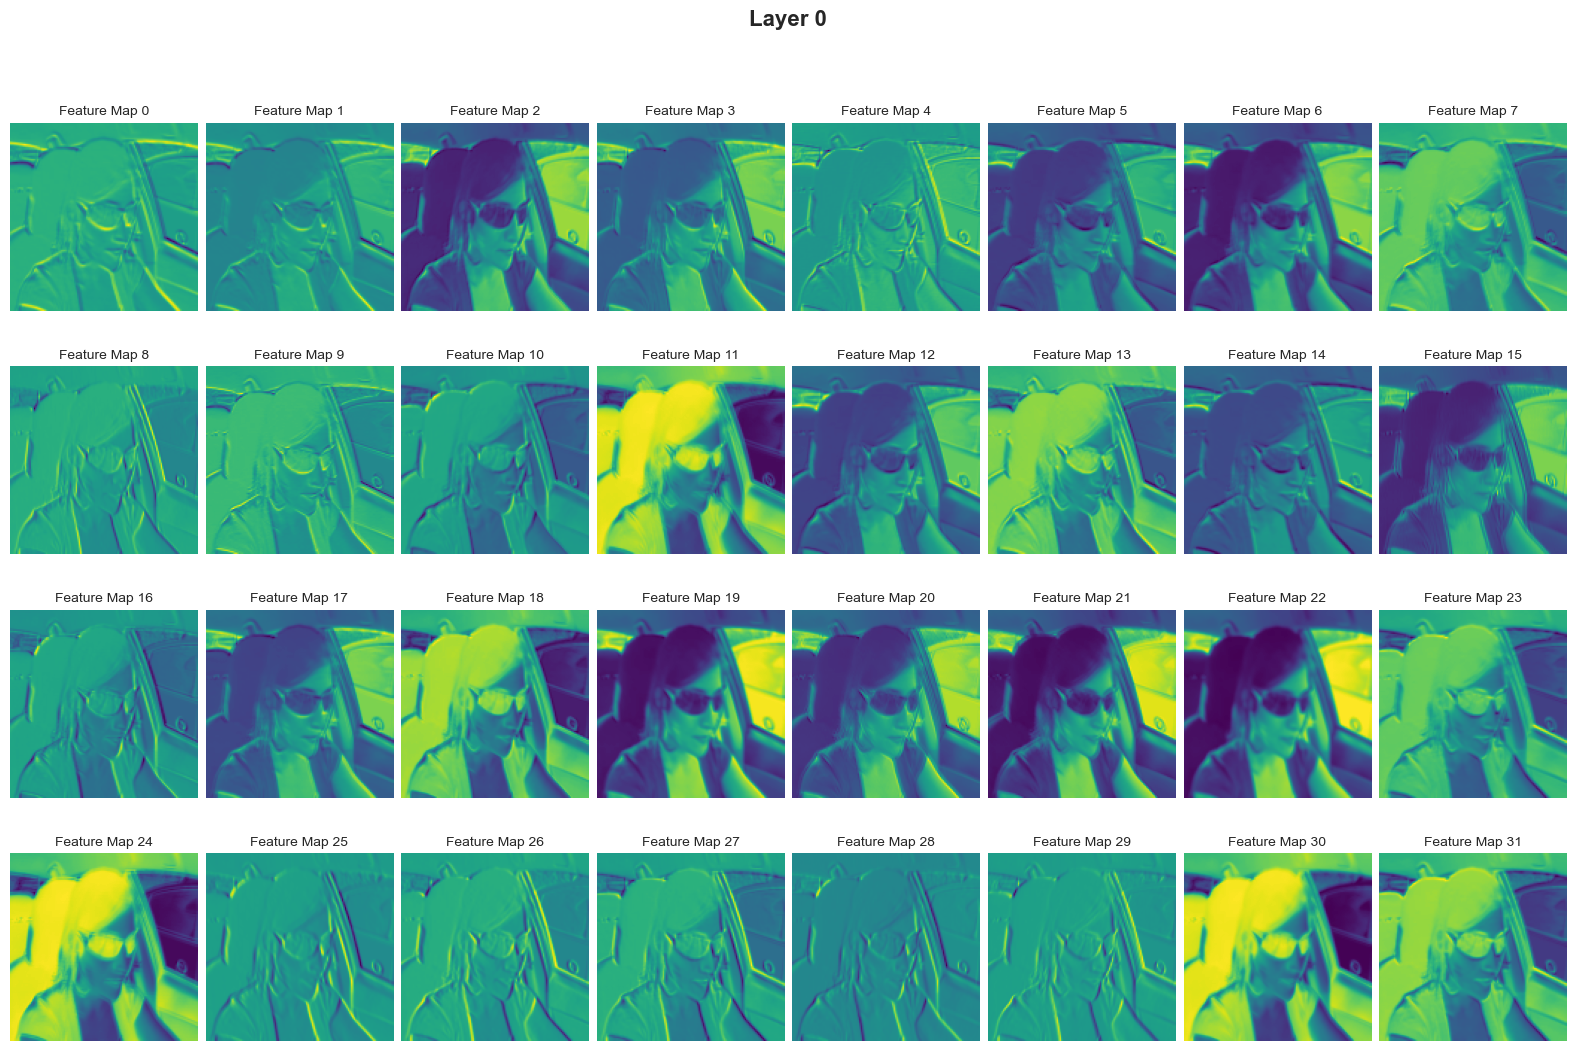

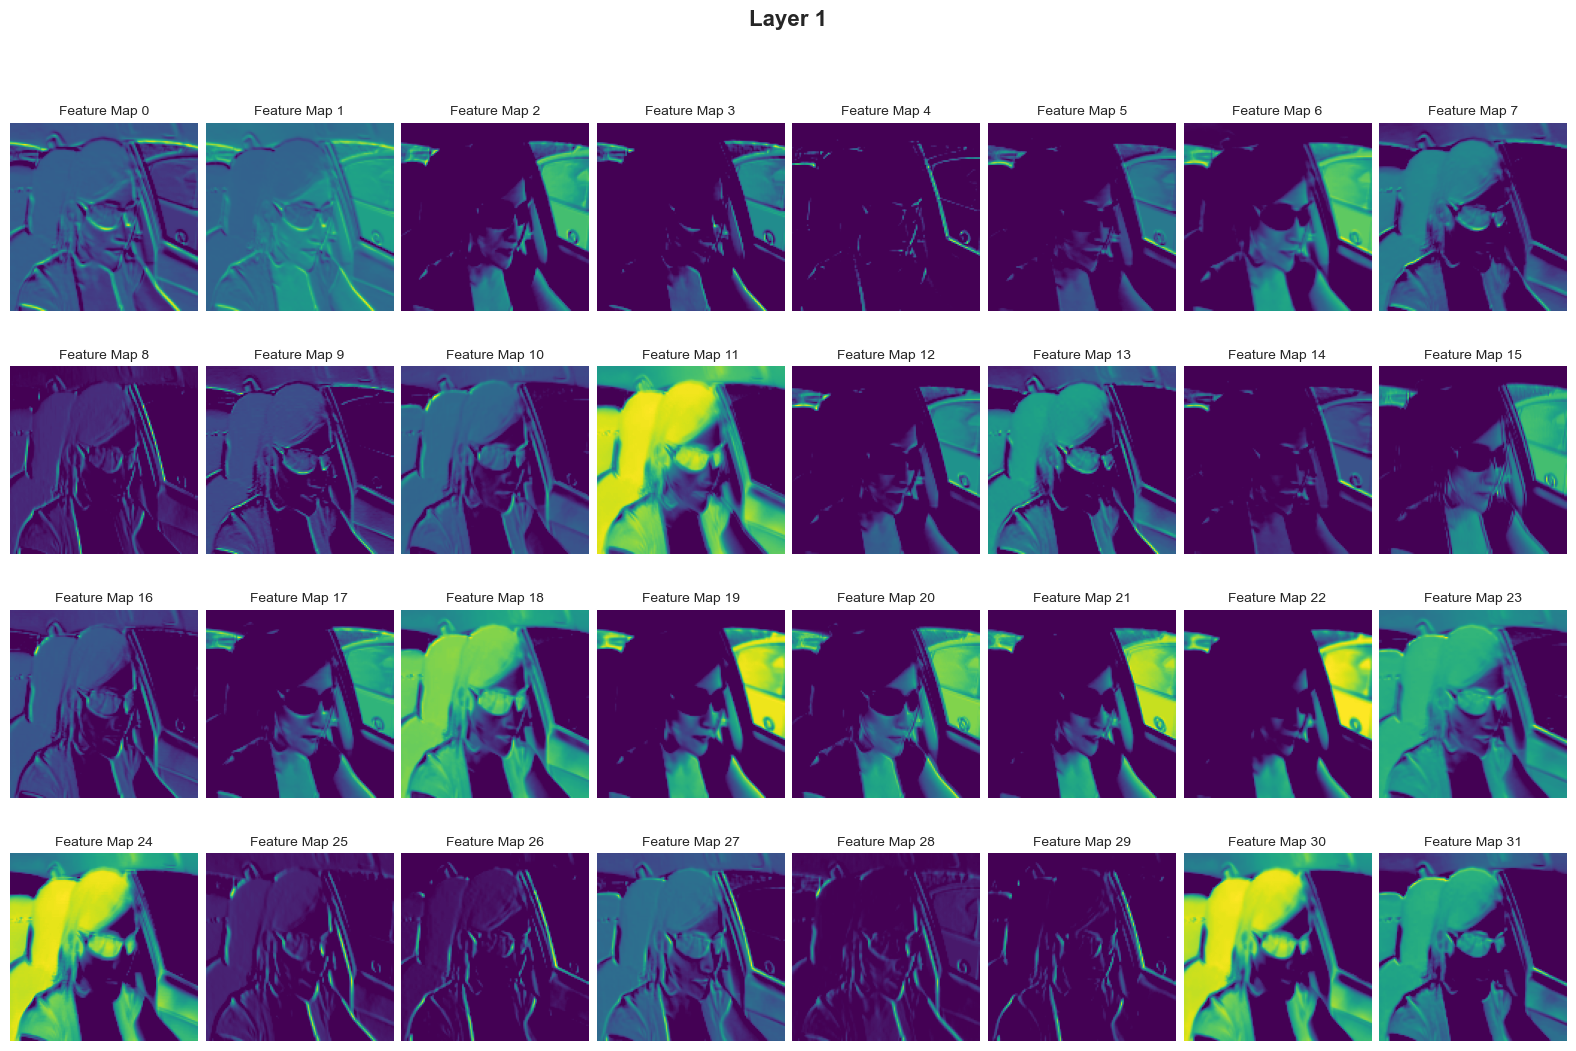

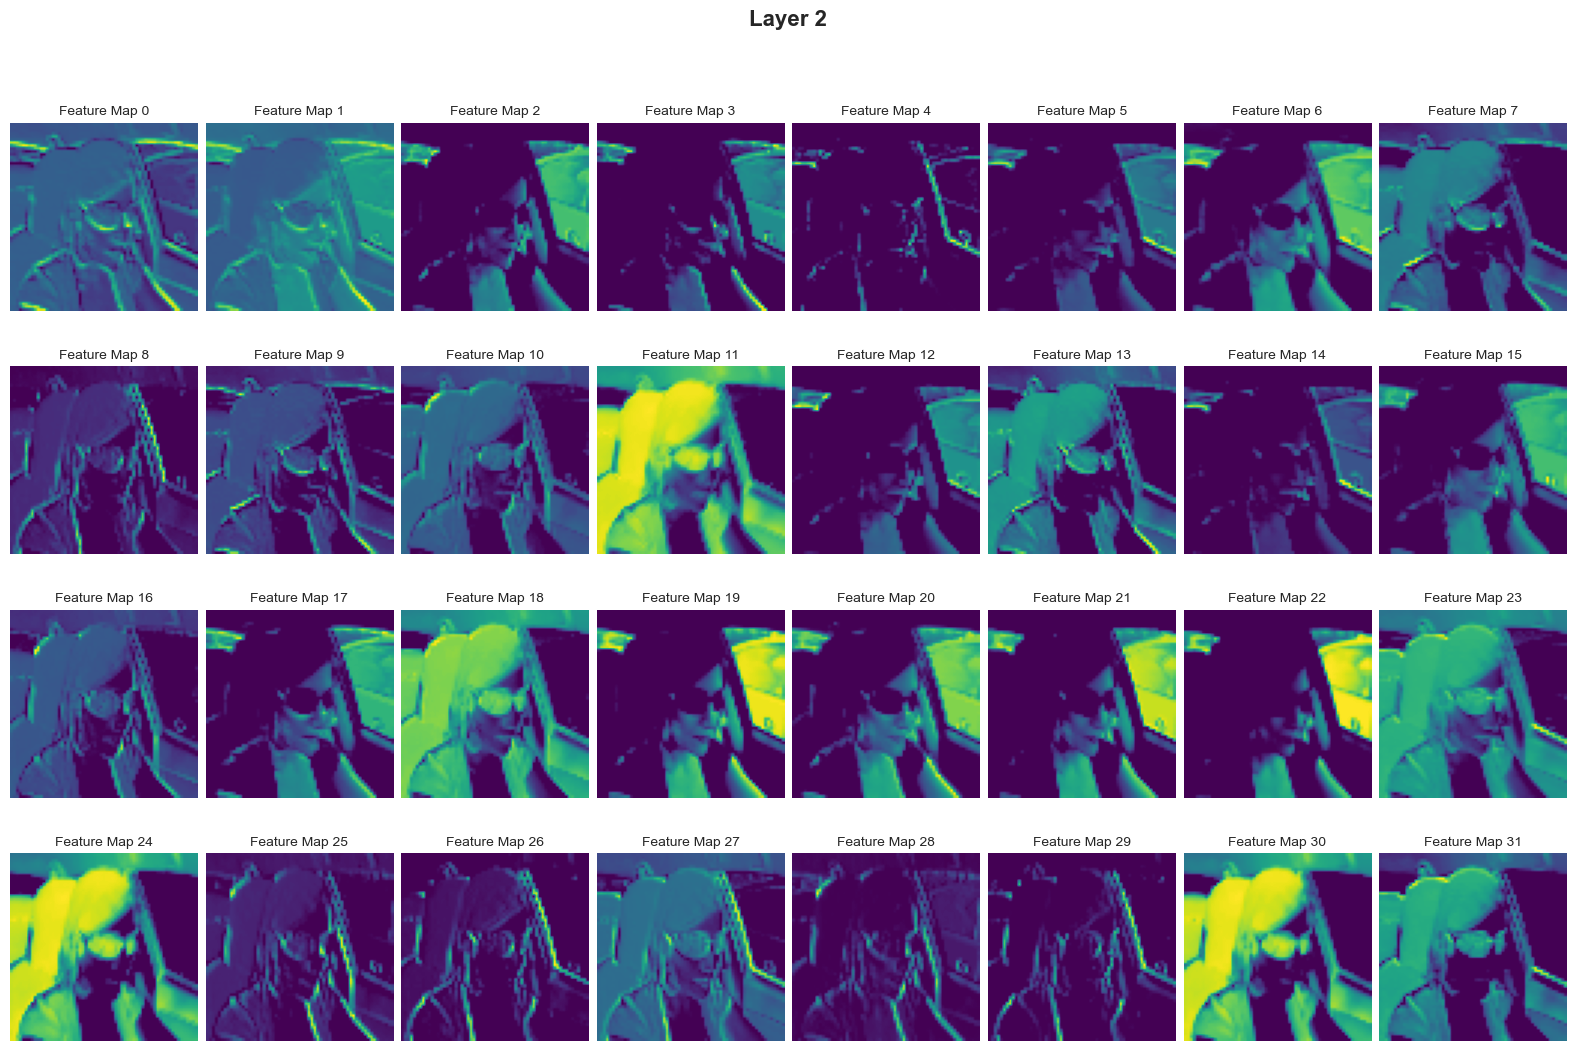

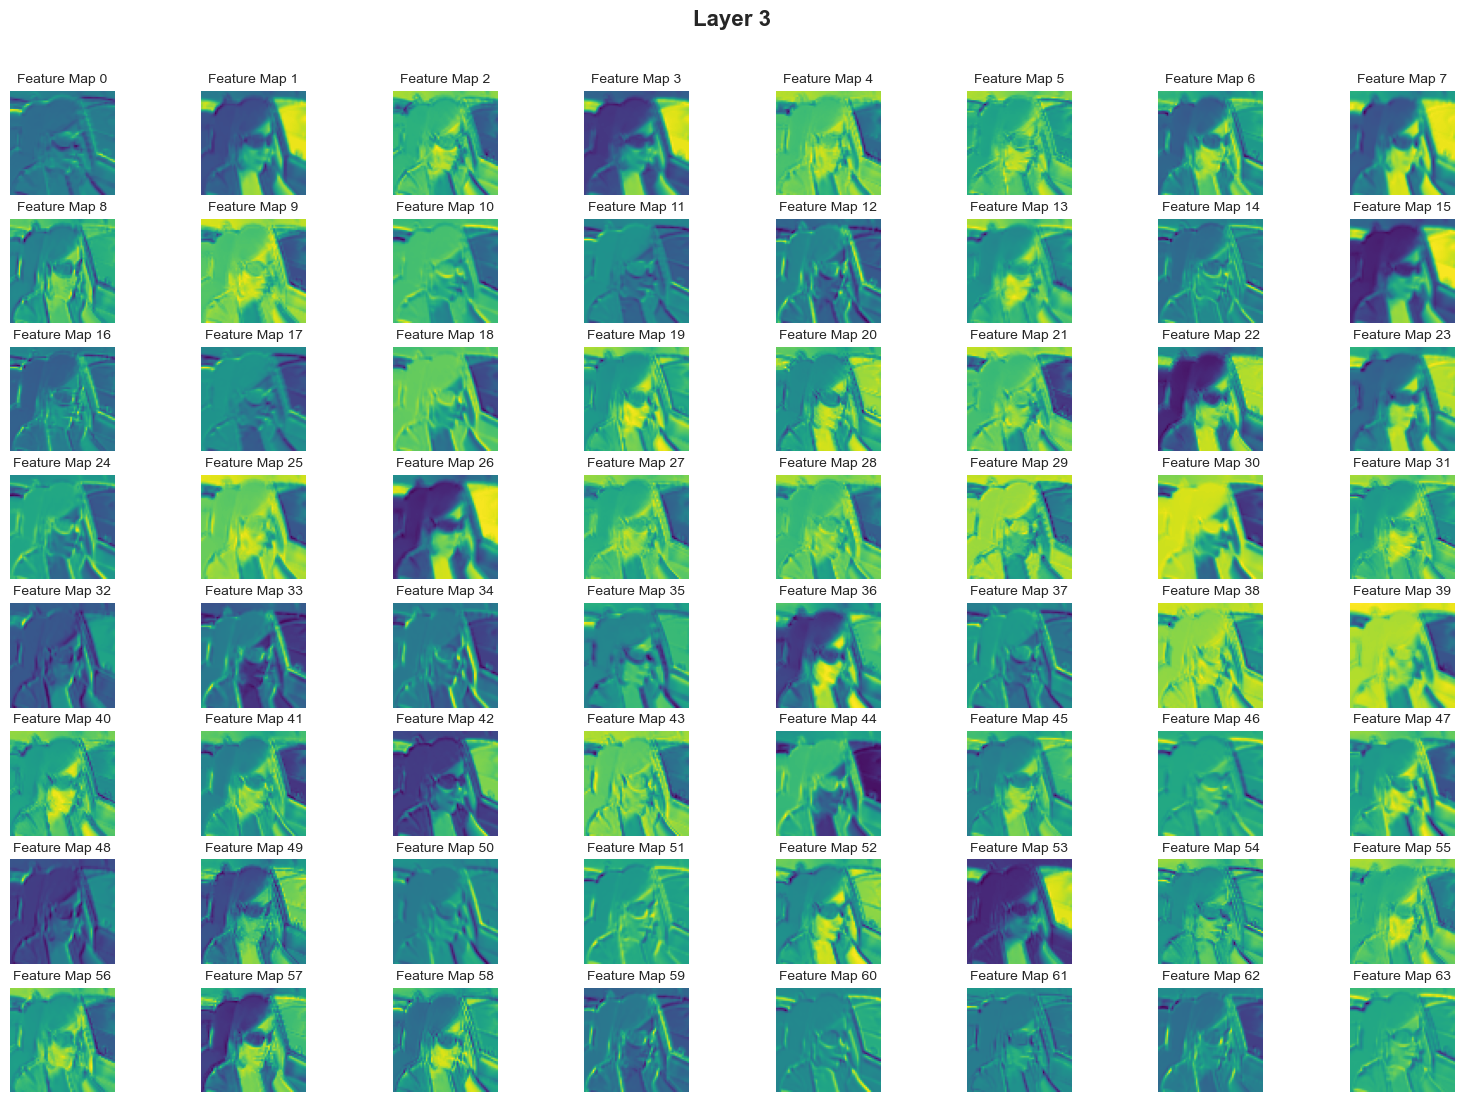

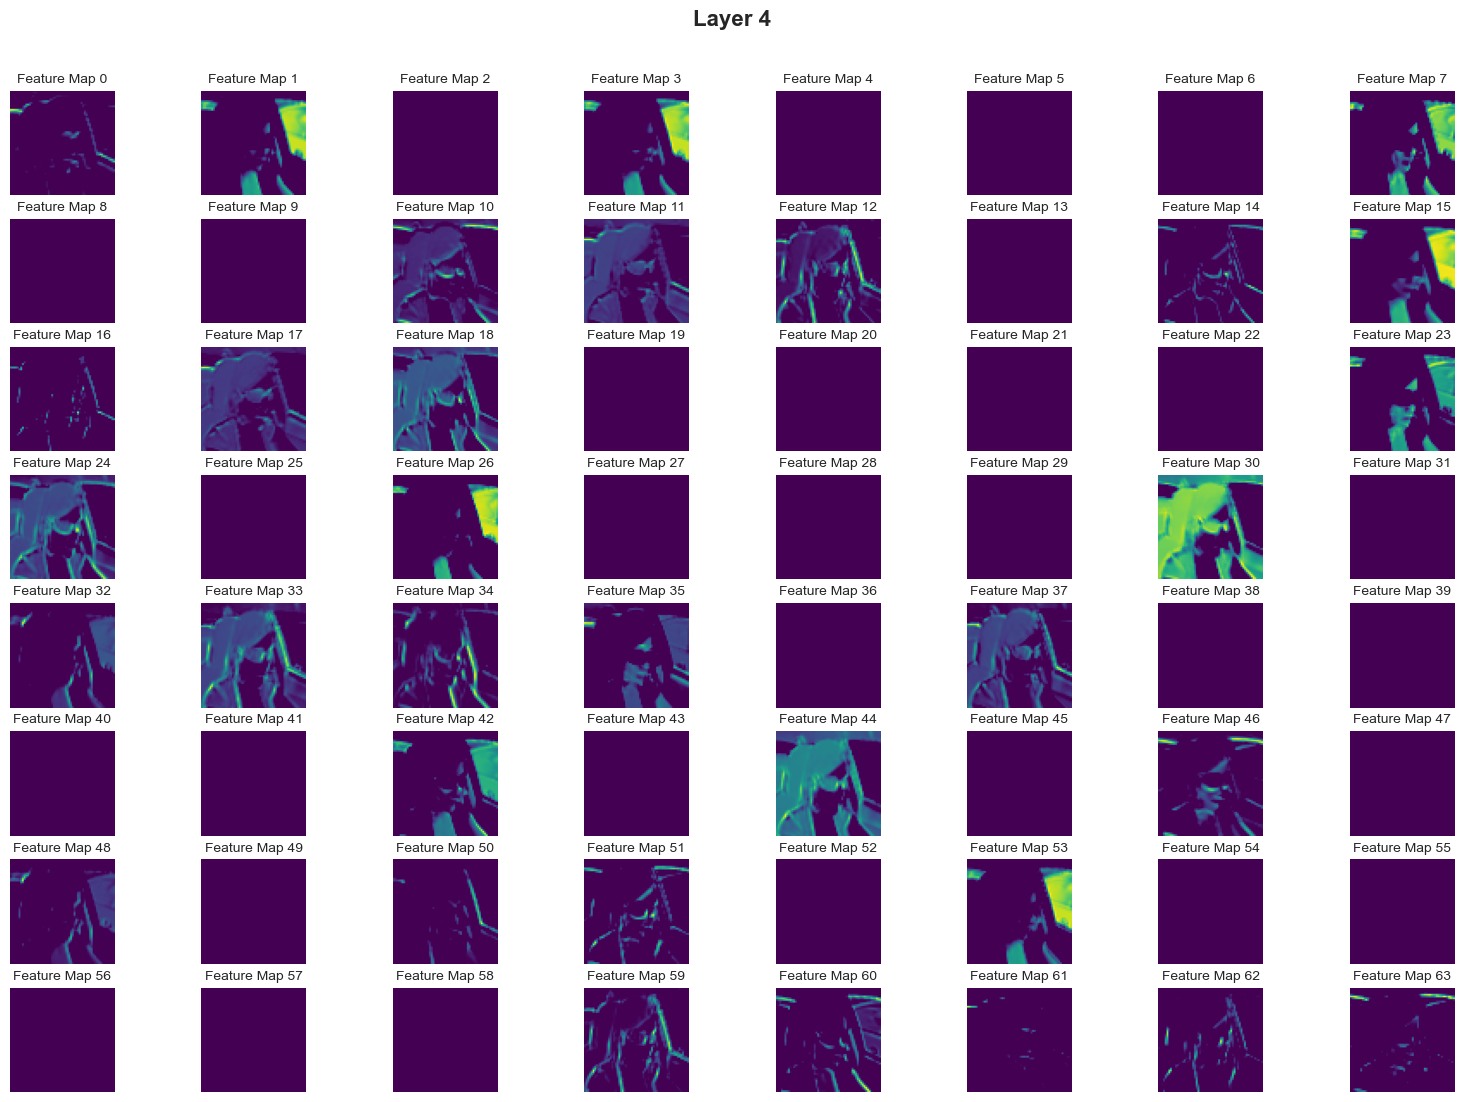

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

# Assume `model` is your neural network model
for name, layer in model.named_children():
    print(f"Layer name: {name}, Layer type: {type(layer)}")

# Function to plot feature maps
def plot_feature_maps(image, model, layer_num):
    # Set the model to evaluation mode
    model.eval()

    # Extract features up to the specified layer
    activations = None
    for index, layer in enumerate(model.children()):
        image = layer(image)
        if index == layer_num:
            activations = image
            break

    if activations is None:
        print("Invalid layer number.")
        return

    # Convert PyTorch tensor to numpy array
    activations = activations.squeeze().detach().cpu().numpy()

    # Plot the feature maps
    num_features = activations.shape[0]
    num_cols = 8  # Number of columns for subplots
    num_rows = (num_features - 1) // num_cols + 1  # Calculate number of rows

    # Reshape activations for desired subplot arrangement
    activations = activations.reshape((num_rows, num_cols, activations.shape[1], activations.shape[2]))

    plt.figure(figsize=(16, 12))
    plt.suptitle(f'Layer {layer_num}', fontsize=16, fontweight='bold', y=0.95)

    for i in range(num_rows):
        for j in range(num_cols):
            ax = plt.subplot(num_rows, num_cols, i * num_cols + j + 1)
            ax.imshow(activations[i, j], cmap='viridis')
            ax.axis('off')
            ax.set_title(f'Feature Map {i * num_cols + j}', fontsize=10)  # Adjust the pad value here
    
    # plt.subplots_adjust(hspace=5)  # Adjust the spacing between rows
    plt.tight_layout(rect=[0, 0.03, 1, 0.95], h_pad=0.3, w_pad=0.4)
    plt.show()

# Example usage
image, _ = train_dataset[0]  # Get a sample image from the dataset
image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

# Loop through all layers and plot feature maps
for layer_num in range(5):
    plot_feature_maps(image, model, layer_num)

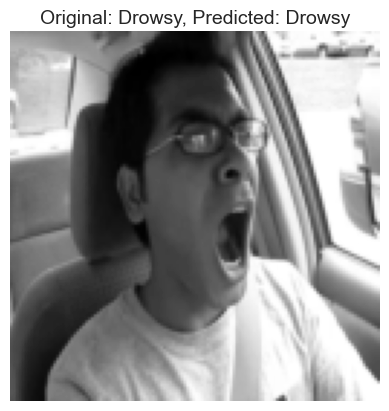

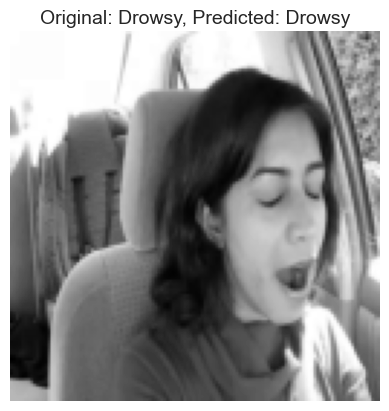

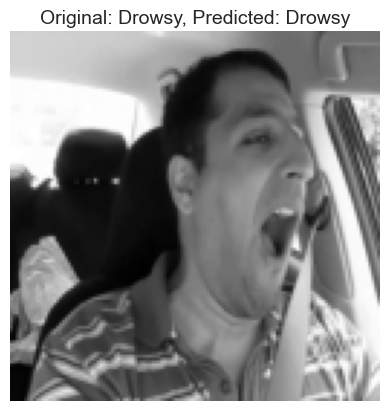

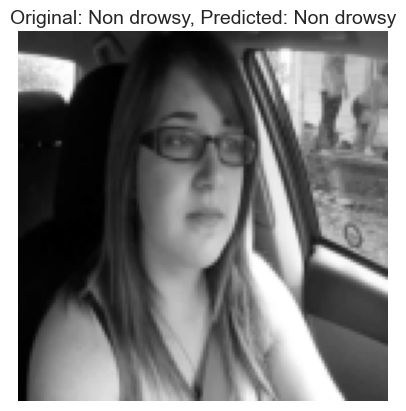

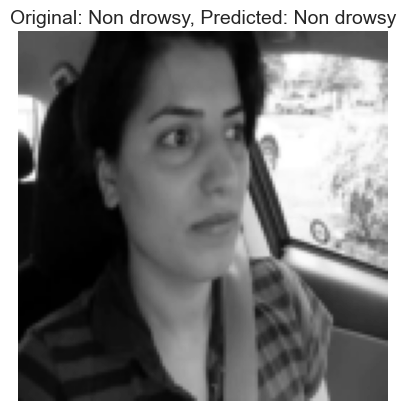

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming test_loader is your test data loader

# Prepare the model for evaluation
model.eval()

# Make predictions on the test set
predicted_classes = []
true_classes = []
original_images = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        predicted = (outputs > 0.5).float().cpu().numpy().flatten()
        true = labels.cpu().numpy().flatten()
        predicted_classes.extend(predicted)
        true_classes.extend(true)
        original_images.extend(images.cpu().numpy())

# Convert numeric labels to class names
class_names = [status_dict[i] for i in range(len(status_dict))]

# # Generate classification report
# print(classification_report(true_classes, predicted_classes, target_names=class_names))

# Display original and predicted images
num_images_to_display = 5  # Number of images to display

indices = np.random.choice(len(original_images), num_images_to_display, replace=False)

for idx in indices:
    original_image = original_images[idx][0]  # Assuming images are grayscale and have shape (1, height, width)
    predicted_class = predicted_classes[idx]
    true_class = true_classes[idx]

    plt.figure()
    plt.title(f"Original: {class_names[int(true_class)]}, Predicted: {class_names[int(predicted_class)]}",fontsize=14)
    plt.imshow(original_image.reshape(128, 128), cmap='gray')
    plt.axis('off')
    plt.show()

In [74]:
# # สร้างโมเดล CNN
# import torch.nn as nn

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv2d(1, 256, kernel_size=3)                # เปลี่ยนจาก 256 เป็น 32
#         self.relu1 = nn.ReLU()
#         self.pool1 = nn.MaxPool2d(kernel_size=2)  
        
#         self.conv2 = nn.Conv2d(256, 128, kernel_size=3)               # เปลี่ยนจาก 128 เป็น 64
#         self.relu2 = nn.ReLU()
#         self.pool2 = nn.MaxPool2d(kernel_size=2)  
        
#         self.conv3 = nn.Conv2d(128, 64, kernel_size=3)                  # เปลี่ยนจาก 64 เป็น 128
#         self.relu3 = nn.ReLU()
#         self.pool3 = nn.MaxPool2d(kernel_size=2)  
        
#         self.conv4 = nn.Conv2d(64, 32, kernel_size=3)             # เปลี่ยนจาก 32 เป็น 256
#         self.relu4 = nn.ReLU()
#         self.pool4 = nn.MaxPool2d(kernel_size=2)  
        
#         self.dropout = nn.Dropout(0.5)
#         self.fc1 = nn.Linear(6 * 6 * 32, 32)                      # เปลี่ยนจาก 6 * 6 * 32 เป็น 6 * 6 * 256
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(32, 1)
#         self.sigmoid = nn.Sigmoid()
        
#     def forward(self, x):
#         x = self.pool1(self.relu1(self.conv1(x)))
#         x = self.pool2(self.relu2(self.conv2(x)))
#         x = self.pool3(self.relu3(self.conv3(x)))
#         x = self.pool4(self.relu4(self.conv4(x)))
#         x = x.view(-1, 6 * 6 * 32)                                     # เปลี่ยนจาก 6 * 6 * 32 เป็น 6 * 6 * 256
#         x = self.dropout(x)
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.fc2(x)
#         x = self.sigmoid(x)
#         return x

# model = CNN().to(device)
# print(model)

In [75]:
# # สร้างโมเดล CNN
# import torch.nn as nn

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv2d(1, 256, kernel_size=3)  # 128x128x3 -> 126x126x256
#         self.relu1 = nn.ReLU()
#         self.pool1 = nn.MaxPool2d(kernel_size=2)  # 126x126x256 -> 63x63x256
        
#         self.conv2 = nn.Conv2d(256, 128, kernel_size=3)  # 63x63x256 -> 61x61x128
#         self.relu2 = nn.ReLU()
#         self.pool2 = nn.MaxPool2d(kernel_size=2)  # 61x61x128 -> 30x30x128
        
#         self.conv3 = nn.Conv2d(128, 64, kernel_size=3)  # 30x30x128 -> 28x28x64
#         self.relu3 = nn.ReLU()
#         self.pool3 = nn.MaxPool2d(kernel_size=2)  # 28x28x64 -> 14x14x64
        
#         self.conv4 = nn.Conv2d(64, 32, kernel_size=3)  # 14x14x64 -> 12x12x32
#         self.relu4 = nn.ReLU()
#         self.pool4 = nn.MaxPool2d(kernel_size=2)  # 12x12x32 -> 6x6x32
        
#         self.dropout = nn.Dropout(0.5)
#         self.fc1 = nn.Linear(6 * 6 * 32, 64)  # 6x6x32 = 1152
#         self.fc2 = nn.Linear(64, 1)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         x = self.pool1(self.relu1(self.conv1(x)))
#         x = self.pool2(self.relu2(self.conv2(x)))
#         x = self.pool3(self.relu3(self.conv3(x)))
#         x = self.pool4(self.relu4(self.conv4(x)))
#         x = x.view(-1, 6 * 6 * 32)  # 6x6x32 = 1152
#         x = self.dropout(x)
#         x = self.fc1(x)
#         x = self.dropout(x)
#         x = self.fc2(x)
#         x = self.sigmoid(x)
#         return x

# # สร้างโมเดล
# model = CNN()
# print(model)


In [76]:
# model = CNN().cuda()

# # กำหนด loss function และ optimizer
# criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# print(model.parameters())

# # ฝึกโมเดล
# train_losses = []
# test_losses = []
# # accuracy_list = []

# for epoch in range(num_epochs):
#     train_loss = 0.0
#     test_loss = 0.0
#     # model.train()
    
#     for images, labels in train_loader:
#         images = images.cuda()
#         labels = labels.cuda()
#         optimizer.zero_grad()
#         outputs = model(images)
#         labels = labels.float().unsqueeze(1)
#         loss = criterion(outputs.squeeze(), labels.squeeze(1))
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item() * images.size(0)

#     train_loss = train_loss / len(train_loader.dataset)
#     train_losses.append(train_loss)
    
#     model.eval()
#     with torch.no_grad():
#         for images, labels in test_loader:
#             images = images.cuda()
#             labels = labels.cuda()
#             outputs = model(images)
#             labels = labels.float().unsqueeze(1)
#             loss = criterion(outputs.squeeze(), labels.squeeze(1))
#             test_loss += loss.item() * images.size(0)

#     print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Test Loss: {test_loss}')
